In [1]:
# %matplotlib ipympl
# %matplotlib notebook
# %matplotlib widget
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import cv2
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import impyute as impy
import tensorflow as tf

physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, enable=True)

from ai_badminton.trajectory import Trajectory
from ai_badminton.hit_detector import AdhocHitDetector, MLHitDetector
from ai_badminton.pose import Pose, read_player_poses, process_pose_file
from ai_badminton.court import Court, read_court
from ai_badminton.video_annotator import annotate_video

In [ ]:
# Import shuttle trajectories and poses
root_name = 'anthony-ginting-beat-kento-momota-anthony-ginting-vs-kento-momota-fo-2019-hlzrivktbyo'

# Get poses and trajectories
trajectory = Trajectory('./data/%s_predict.csv' % root_name, interp=False)

# Get video
cap = cv2.VideoCapture('./data/%s.mp4' % root_name)
if cap.isOpened() is False:
    print('Error opening video stream or file')

fps = cap.get(cv2.CAP_PROP_FPS)

In [ ]:
# Some outlier detection programs
# from sklearn.ensemble import IsolationForest

# outliers_fraction = 0.05
# model =  IsolationForest(contamination=outliers_fraction)
# model.fit(trajectory.Y_pred.values.reshape(-1, 1)) 
# trajectory['anomaly_Y'] = pd.Series(model.predict(trajectory.Y_pred.values.reshape(-1, 1)))

# # visualization
# trajectory['anomaly_Y'] = pd.Series(trajectory['anomaly_Y'].values, index=trajectory.index)
# a = trajectory.loc[trajectory['anomaly_Y'] == -1] #anomaly
# _ = plt.figure(figsize=(18,6))
# _ = plt.plot(trajectory['Y_pred'], color='blue', label='Normal')
# _ = plt.plot(a['Y_pred'], linestyle='none', marker='X', color='red', markersize=12, label='Anomaly')
# plt.show()

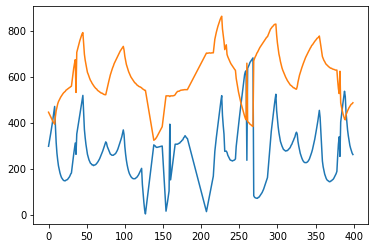

In [ ]:
plt.plot(range(400), trajectory.Y[:400])
plt.plot(range(400), trajectory.X[:400])
plt.show()

In [6]:
court = Court(
    read_court('./data/%s_court.out' % root_name)
)

In [7]:
# # If pose files are not yet processed, do this:
# poses = process_pose_file(
#     './data/%s_poses_mmpose.out' % root_name, 
#     './output/%s' % root_name, 
#     court,
#     fullPose=True
# )

In [8]:
poses = read_player_poses('./output/%s' % root_name)

Total shots hit by players: 271
Total impacts detected: 378
Distribution of shot times:
Average time between shots (s): 1.3593633952254642


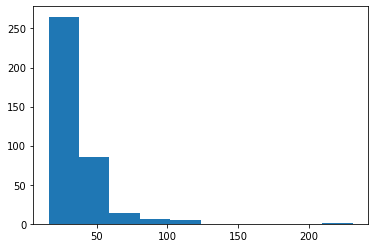

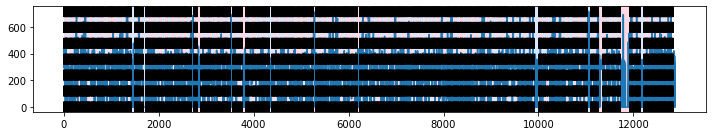

In [9]:
import ruptures as rpt

# signal
signal_x = np.array(trajectory.X)
signal_y = np.array(trajectory.Y)

# detection
detector = AdhocHitDetector(poses, trajectory)
result, is_hit = detector.detect_hits(fps)

# display
rpt.display(signal_y, result, result)
plt.show()

In [160]:
# New hit detection
os.chdir('/home/code-base/user_space/ai-badminton/notebooks')

In [234]:
from tensorflow.python.keras.saving import hdf5_format
import h5py
from tensorflow.keras import backend as K

def scale_by_col(x, cols):
    x_ = x[:, cols]
    m, M = np.min(x_[x_ != 0]), np.max(x_[x_ != 0])
    x_[x_ != 0] = (x_[x_ != 0] - m) / (M - m) + 1
    x[:, cols] = x_
    return x

def scale_data(x):
    even_cols = [2*i for i in range(x.shape[1] // 2)]
    odd_cols = [2*i+1 for i in range(x.shape[1] // 2)]
    x = scale_by_col(x, even_cols)
    x = scale_by_col(x, odd_cols)
    return x

dependencies = {
    'kl_divergence': tf.keras.metrics.KLDivergence
}

model_path = './../TrackNetv2/3_in_3_out/hitnet_conv_model_predict_direction.h5'
with h5py.File(model_path, mode='r') as f:
    temperature = f.attrs['temperature']
    model = hdf5_format.load_model_from_hdf5(f, custom_objects=dependencies)
            
Xb, Yb = trajectory.X, trajectory.Y
num_consec = int(model.input_shape[1] // (2 * (34 + 4 + 1)))
court_pts = court.corners
corner_coords = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()

bottom_player = poses[0]
top_player = poses[1]

corners = np.array([court_pts[1], court_pts[2], court_pts[0], court_pts[3]]).flatten()

x_list = []
L = min(bottom_player.values.shape[0], len(Xb))
for i in range(num_consec):
    end = L-num_consec+i+1
    x_bird = np.array(list(zip(Xb[i:end], Yb[i:end])))
    x_pose = np.hstack([bottom_player.values[i:end], top_player.values[i:end]])
    x = np.hstack([x_bird, x_pose, np.array([corners for j in range(i, end)])])

    x_list.append(x)
x_inp = np.hstack(x_list)
x_inp = scale_data(x_inp)        

compute_logits = K.function([model.layers[0].input], [model.layers[-2].output])
y_pred = tf.nn.softmax(compute_logits(x_inp)[0] / temperature).numpy()
#         y_pred = self.model.predict(x_inp)

# detections = np.where(y_pred[:,0] < 0.1)[0]
# result, clusters, who_hit = [], [], []
# min_x, max_x = np.min(court_pts, axis=0)[0], np.max(court_pts, axis=0)[0]
# for t in detections:
#     # Filter based on time
#     if len(clusters) == 0 or clusters[-1][0] < t - fps / 2:
#         clusters.append([t])
#     else:
#         clusters[-1].append(t)

# print('Sum of predicted scores:', np.sum(y_pred, axis=0))

# delta = 0.1 * (max_x - min_x)
# for cluster in clusters:
#     # Filter based on whether any part of the cluster is outside
#     any_out = False
#     votes = np.array([0.] * y_pred.shape[1])
#     for t in cluster:
#         if Xb[t] < min_x + delta or Xb[t] > max_x - delta:
#             any_out = True
#             break
#         votes += y_pred[t]
#     if not any_out:
#         # Detections start around 6 frames from the end
#         result.append(int(np.median(cluster) + num_consec - 6))
#         who_hit.append(int(np.argmax(votes)))

# is_hit = []
# avg_hit = np.average(np.diff(result))
# last_hit, last_time = -1, -1
# to_delete = [0] * len(result)
# for i, fid in enumerate(result):
# #             if i+1 < len(result) and result[i+1] - fid > 1.6 * avg_hit:
# #                 is_hit.append(0)
# #                 continue
#     if i >= len(who_hit):
#         break

#     # Another filter: prevent two hits in a row by the same person within 0.8s
#     if fid - last_time < 0.8 * fps and last_hit == who_hit[i]:
#         to_delete[i] = 1
#         continue

#     is_hit.append(who_hit[i])
#     last_time = fid
#     last_hit = who_hit[i]

# result = [r for i, r in enumerate(result) if not to_delete[i]]

# num_hits = sum(x > 0 for x in is_hit)
# print('Total shots hit by players:', )
# if num_hits:
#     print('Percentage of shots hit by player 1:', sum(x == 1 for x in is_hit) / num_hits)
# else:
#     print('No hits detected.')
# print('Total impacts detected:', len(result))
# print('Distribution of shot times:')
# plt.hist(np.diff(result))
# print('Average time between shots (s):', np.average(np.diff(result)) / fps)
# return result, is_hit

In [235]:
def savitzky_golay(y, window_size, order, deriv=0, rate=1):
    r"""Smooth (and optionally differentiate) data with a Savitzky-Golay filter.
    The Savitzky-Golay filter removes high frequency noise from data.
    It has the advantage of preserving the original shape and
    features of the signal better than other types of filtering
    approaches, such as moving averages techniques.
    Parameters
    ----------
    y : array_like, shape (N,)
        the values of the time history of the signal.
    window_size : int
        the length of the window. Must be an odd integer number.
    order : int
        the order of the polynomial used in the filtering.
        Must be less then `window_size` - 1.
    deriv: int
        the order of the derivative to compute (default = 0 means only smoothing)
    Returns
    -------
    ys : ndarray, shape (N)
        the smoothed signal (or it's n-th derivative).
    Notes
    -----
    The Savitzky-Golay is a type of low-pass filter, particularly
    suited for smoothing noisy data. The main idea behind this
    approach is to make for each point a least-square fit with a
    polynomial of high order over a odd-sized window centered at
    the point.
    Examples
    --------
    t = np.linspace(-4, 4, 500)
    y = np.exp( -t**2 ) + np.random.normal(0, 0.05, t.shape)
    ysg = savitzky_golay(y, window_size=31, order=4)
    import matplotlib.pyplot as plt
    plt.plot(t, y, label='Noisy signal')
    plt.plot(t, np.exp(-t**2), 'k', lw=1.5, label='Original signal')
    plt.plot(t, ysg, 'r', label='Filtered signal')
    plt.legend()
    plt.show()
    References
    ----------
    .. [1] A. Savitzky, M. J. E. Golay, Smoothing and Differentiation of
       Data by Simplified Least Squares Procedures. Analytical
       Chemistry, 1964, 36 (8), pp 1627-1639.
    .. [2] Numerical Recipes 3rd Edition: The Art of Scientific Computing
       W.H. Press, S.A. Teukolsky, W.T. Vetterling, B.P. Flannery
       Cambridge University Press ISBN-13: 9780521880688
    """
    import numpy as np
    from math import factorial
    
    try:
        window_size = np.abs(int(window_size))
        order = np.abs(np.int(order))
    except ValueError:
        raise ValueError("window_size and order have to be of type int")
    if window_size % 2 != 1 or window_size < 1:
        raise TypeError("window_size size must be a positive odd number")
    if window_size < order + 2:
        raise TypeError("window_size is too small for the polynomials order")
    order_range = range(order+1)
    half_window = (window_size -1) // 2
    # precompute coefficients
    b = np.mat([[k**i for i in order_range] for k in range(-half_window, half_window+1)])
    m = np.linalg.pinv(b).A[deriv] * rate**deriv * factorial(deriv)
    # pad the signal at the extremes with
    # values taken from the signal itself
    firstvals = y[0] - np.abs( y[1:half_window+1][::-1] - y[0] )
    lastvals = y[-1] + np.abs(y[-half_window-1:-1][::-1] - y[-1])
    y = np.concatenate((firstvals, y, lastvals))
    return np.convolve( m[::-1], y, mode='valid')

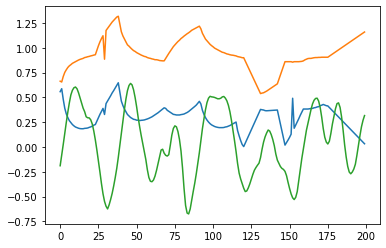

390


In [237]:
from scipy.signal import medfilt, savgol_filter

L = 200
plt.plot(range(L), np.array(trajectory.Y[7:7+L]) / 800)
plt.plot(range(L), np.array(trajectory.X[7:7+L]) / 600)
# plt.show()
# plt.plot(y_pred[:400, 1])
# plt.plot(y_pred[:400, 2])
# z = medfilt(np.argmax(y_pred, axis=1), 7)
z = savgol_filter(y_pred[:,1] - y_pred[:, 2], 15, 3)
# z = y_pred
plt.plot(z[:L])
plt.show()

last = 0
hits = 0
result = []
is_hit = []
for i in range(z.shape[0]-1):
    if i-last > 0.7*30 and z[i] * z[i+1] < 0:
        last = i
        hits += 1
        result.append(7+i)
        is_hit.append(2 if z[i] > z[i+1] else 1)
print(hits)

In [199]:
len(result)

397

In [181]:
detector = MLHitDetector(
    court,
    poses,
    trajectory,
    './../TrackNetv2/3_in_3_out/hitnet_conv_model_predict_player.h5'
)

Number of layers: 9
Total params: 16355
Trainable params: 16355
Non-trainable params: 0


Sum of predicted scores: [9392.061  1919.5753 1556.4529]
Total shots hit by players:
Percentage of shots hit by player 1: 0.5718232044198895
Total impacts detected: 362
Distribution of shot times:
Average time between shots (s): 1.4144044321329639


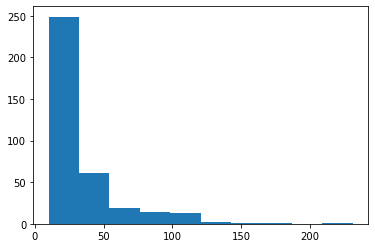

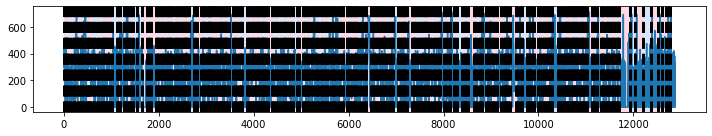

In [12]:
result, is_hit = detector.detect_hits(fps)
rpt.display(signal_y, result, result)
plt.show()

In [233]:
annotate_video(
    cap,
    court,
    poses,
    trajectory,
    result,
    is_hit,
    frame_limit=800
)

  0%|          | 0/800 [00:00<?, ?it/s]

In [65]:
from IPython.display import HTML

HTML("""
    <video alt="test" width="780" controls>
        <source src="./output/output.mp4" type="video/mp4">
    </video>
""")

In [162]:
# Find sequences of fully formed rallies
started = False
spos, lpid = 0, 0
num_rallies, rally_len = 0, 0
rallies = []
for i, pid in enumerate(is_hit):
    if pid > 0 and not started:
        # Start the chain
        spos, lpid = i, pid
        started = True
        rally_len = 1
    elif started:
        if pid == 0:
            started = False
            if rally_len >= 2:
                print('Rally length:', rally_len)
                rallies.append([result[spos], result[i]])
        elif pid == lpid:
            rally_len = 0
            spos = i
        else:
            lpid = pid
            rally_len += 1
            
print(len(rallies))

Rally length: 5
Rally length: 4
Rally length: 22
Rally length: 3
Rally length: 14
Rally length: 12
Rally length: 2
Rally length: 4
Rally length: 9
Rally length: 2
Rally length: 2
Rally length: 2
Rally length: 5
Rally length: 3
Rally length: 7
Rally length: 9
Rally length: 11
Rally length: 4
Rally length: 2
Rally length: 4
Rally length: 3
Rally length: 5
Rally length: 7
Rally length: 4
Rally length: 5
Rally length: 12
Rally length: 9
Rally length: 2
Rally length: 11
29


In [36]:
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))  # float `height`
    
for rid, rally in enumerate(rallies):
    print('Processing rally', rid)
    print('Rally duration', (rally[1] - rally[0]) / fps)
    cap.set(cv2.CAP_PROP_POS_FRAMES, rally[0])
    outvid = cv2.VideoWriter(
        './output/rallies/' + str(rid) + '.mp4', 
        cv2.VideoWriter_fourcc('M','P','4','V'), 
        fps, 
        (width, height)
    )

    for i in range(rally[0], rally[1]+10):
        ret, frame = cap.read()
        outvid.write(frame)
    outvid.release()

Processing rally 0
Rally duration 6.36
Processing rally 1
Rally duration 7.6
Processing rally 2
Rally duration 14.0
Processing rally 3
Rally duration 2.64
Processing rally 4
Rally duration 3.84
Processing rally 5
Rally duration 8.08
Processing rally 6
Rally duration 2.4
Processing rally 7
Rally duration 6.4
Processing rally 8
Rally duration 6.56
Processing rally 9
Rally duration 7.76
Processing rally 10
Rally duration 2.4
Processing rally 11
Rally duration 5.04
Processing rally 12
Rally duration 3.32
Processing rally 13
Rally duration 9.84
Processing rally 14
Rally duration 1.28
Processing rally 15
Rally duration 15.6
Processing rally 16
Rally duration 8.56
Processing rally 17
Rally duration 6.8
Processing rally 18
Rally duration 3.28
Processing rally 19
Rally duration 4.04
Processing rally 20
Rally duration 2.72
Processing rally 21
Rally duration 2.04
Processing rally 22
Rally duration 2.72
Processing rally 23
Rally duration 2.88
Processing rally 24
Rally duration 1.72
Processing rall

In [125]:
os.getcwd()

'/trainman-mount/trainman-k8s-storage-6677a55e-8792-44ee-923d-9ed5edea05ca/ai-badminton/notebooks'